In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

# load preprocessed data

In [0]:
# load pre-processed data
# replace with local file-path if you're running on local python shell
train_X= pd.read_csv('/content/drive/My Drive/1003 project/train_X.csv')
train_y= pd.read_csv('/content/drive/My Drive/1003 project/train_y.csv')
val_X = pd.read_csv('/content/drive/My Drive/1003 project/val_X.csv')
val_y = pd.read_csv('/content/drive/My Drive/1003 project/val_y.csv')

In [6]:
train_X.head()

,ex_id,user_id,prod_id,rating,date,review,cleaned review
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...,b'the food snack select popular greek dish the...
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...,b'this littl place soho wonder lamb sandwich g...
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,b'order lunch snack last friday time noth miss...
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...,b'this beauti quaint littl restaur pretti stre...
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...,b'snack great place casual sit especi cold win...


Note that right now, the cleaned reviews are byte strings instead of normal strings, hence the b' ' enclosing the string.

In [0]:
#add new features: text length and word length. This probably be useful
train_X['text length'] = train_X['review'].apply(len)
train_X['word length'] = train_X['review'].apply(lambda x: len(x.split(" "))) 

val_X['text length'] = val_X['review'].apply(len)
val_X['word length'] = val_X['review'].apply(lambda x: len(x.split(" ")))

# text length: the number of characters (including white spaces) in the string
# word length: the number of words in the string

In [8]:
train_X.head()

,ex_id,user_id,prod_id,rating,date,review,cleaned review,text length,word length
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...,b'the food snack select popular greek dish the...,215,40
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...,b'this littl place soho wonder lamb sandwich g...,269,52
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,b'order lunch snack last friday time noth miss...,178,32
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...,b'this beauti quaint littl restaur pretti stre...,491,90
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...,b'snack great place casual sit especi cold win...,596,102


In [9]:
train_y.head()

,label
0,1
1,1
2,1
3,1
4,1


In [10]:
val_X.shape

(35918, 9)

# upsample fake reviews to deal with class imbalance and improve model learning accuracy

In [11]:
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# create a raondom sampler object from the class
ros = RandomOverSampler()

In [13]:
# create re-sampled data from the original data
# The augmented data set should be used instead of the original data set to train a classifier
train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# on local python shell, the trian_X_ros after oversampling is still DataFrame
# But on colab version it turned to array, so we need to change it back to a pd.df
train_X_ros = pd.DataFrame(train_X_ros, columns = ['ex_id','user_id','prod_id','rating','date','review','cleaned review','text length','word length'])
train_y_ros = pd.DataFrame(train_y_ros, columns = ['label'])

In [15]:
print('pre-upsampling genuine cases: ',train_y[train_y['label'] == 0].shape[0])
print('post-upsampling genuine cases: ',train_y_ros[train_y_ros['label'] == 0].shape[0])
print()
print('pre-upsampling fake cases: ',train_y[train_y['label'] == 1].shape[0])
print('post-upsampling fake cases: ',train_y_ros[train_y_ros['label'] == 1].shape[0])

pre-upsampling genuine cases:  225055
post-upsampling genuine cases:  225055

pre-upsampling fake cases:  25819
post-upsampling fake cases:  225055


now, the number of fake reviews is the same as the number of genuine reviews. We have fixed the class-imbalance issue.

# Text to vector conversion

## bag of words

Bag of Words basically creates a dictionary of `d` words (this is not a python dictionary) where `d` is the number of unique words in our text corpus. It then creates `d` dimensional vectors (consider it an array of length `d`) for each document (review) in our corpus (total set of reviews) and each dimension (cell) has value equal to number of times the corresponding word has occurred in that particular document (review).

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# create an object from class
# by default, CountVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
count_vect = CountVectorizer()

# learn (fit) the vocab dictionry and vetorize (transform) each review
BoW_train_X = count_vect.fit_transform(train_X_ros['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [18]:
BoW_train_X

<450110x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 19940984 stored elements in Compressed Sparse Row format>

We can see that the matrix has the number of reviews as rows and 73944 unique words in all reviews

we also have to trasnform our validation set
but be careful, we cannot train the vectorizer on the validation set, because after training, our model only knows how to classify inputs that has the same # of features. So if we had fit our vectorizer on the validation set, it might result in a matrix with different numbers of features.

In [0]:
BoW_val_X = count_vect.transform(val_X['cleaned review'])

In [20]:
BoW_val_X

<35918x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 1814781 stored elements in Compressed Sparse Row format>

Note how that although the number of rows changed (to equal to the same number of reviews in the validation set), the number of columns is the same as our training BoW set!

First, we can just use the BoW matrix, i.e., the unique-word features as our only features and start training the model. But later, we can also add in features such as rating, and text length to see if it betters our result! But if we add these other features, make sure to normalize them as they can be quite large numbers

In [0]:
# let's add the additional features to the training matrix
train_extra = np.array(train_X_ros[['text length','word length','rating']], dtype=float)

# normalize the extra features
train_extra_min = train_extra.min(axis = 0) # get the min value for each column
train_extra_max = train_extra.max(axis = 0) # get the max value for each column
train_extra = (train_extra - train_extra_min)/(train_extra_max-train_extra_min) # normalize each column to be between 0~1

# add these columns to our BoW matrix, remember to keep the sparse format
BoW_train_X_extra = sparse.hstack((BoW_train_X, train_extra))

In [0]:
# do the same for the validation X data

# let's add the additional features to the validation matrix
val_extra = np.array(val_X[['text length','word length','rating']], dtype=float)

# normalize the extra features
val_extra_min = val_extra.min(axis = 0) # get the min value for each column
val_extra_max = val_extra.max(axis = 0) # get the max value for each column
val_extra = (val_extra - val_extra_min)/(val_extra_max-val_extra_min) # normalize each column to be between 0~1

# add these columns to our BoW matrix, remember to keep the sparse format
BoW_val_X_extra = sparse.hstack((BoW_val_X, val_extra))

## TF-IDF

# Single model (SVM) trianing

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, confusion_matrix

In [24]:
# change the y-labels to ndarray of shape (n_samples, ) for model inputs
train_y_ros_arr = np.array(train_y_ros['label'])
print(train_y_ros_arr.shape)

val_y_arr = np.array(val_y['label'])
print(val_y_arr.shape)

(450110,)
(35918,)


## BoW data

In [0]:
# create the svc model object
svclassifier = SVC(kernel='linear')

In [0]:
# fit the model to our training data
# do not start running this if you're not prepared to wait for 3 hours
svclassifier.fit(BoW_train_X, train_y_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As stated by the API, `svc` does not handle large datasets (> 10,000 instances) well, and this fit took forever! For large datasets consider using `sklearn.svm.LinearSVC` or `sklearn.linear_model.SGDClassifier` instead. However, those are all linear kernel models and does not offer me the option of choosing kernels such as `sigmoid` or `poly`. Any work around?

Look into `sklearn.kernel_approximation.Nystroem` at https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

In [26]:
# fit the model to our training data
sgd.fit(BoW_train_X, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X)
# this returns a ndarray of shape (n_samples, )

In [28]:
val_pred.shape

(35918,)

In [29]:
roc_auc_score(val_y_arr, val_pred)

0.6572681024687531

In [30]:
average_precision_score(val_y_arr, val_pred)

0.14619804580348653

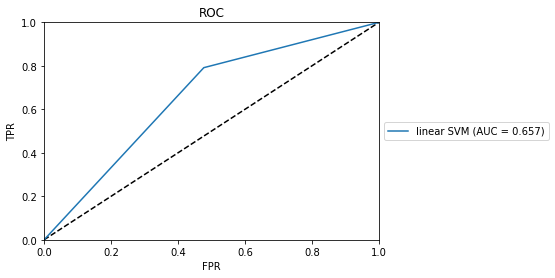

In [31]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

fpr, tpr, thresholds = roc_curve(val_y_arr, val_pred)
curve = plt.plot(fpr, tpr, label = 'linear SVM' + ' (AUC = %0.3f)' % roc_auc_score(val_y_arr, val_pred))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [32]:
confusion_matrix(val_y_arr, val_pred)

array([[16873, 15397],
       [  760,  2888]])

Thus in binary classification, the count of true negatives is :`C_{0,0}`, false negatives is :`C_{1,0}`, true positives is :`C_{1,1}` and false positives is :`C_{0,1}`.

In [33]:
pd.DataFrame(confusion_matrix(val_y_arr, val_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive'])

,predicted negative,predicted positive
actual negative,16873,15397
actual positive,760,2888


## BoW_extra data

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

In [35]:
# fit the model to our training data with extra features
sgd.fit(BoW_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

In [37]:
roc_auc_score(val_y_arr, val_pred)

0.6587193393597877

In [38]:
average_precision_score(val_y_arr, val_pred)

0.14910364605554677

Well, both metrics are a tiny bit better. So we will use the matrix that inludes these extra features from now on.

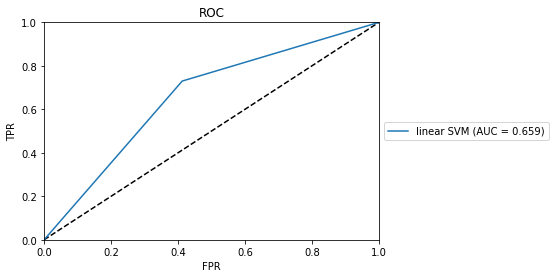

In [39]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

fpr, tpr, thresholds = roc_curve(val_y_arr, val_pred)
curve = plt.plot(fpr, tpr, label = 'linear SVM' + ' (AUC = %0.3f)' % roc_auc_score(val_y_arr, val_pred))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [40]:
pd.DataFrame(confusion_matrix(val_y_arr, val_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive'])

,predicted negative,predicted positive
actual negative,18957,13313
actual positive,985,2663


Although we have have less true negatives, we do now have more true positives.

In [0]:
# create a function to print all the results in one place

def get_results(y_true, y_pred):
  '''
  Params:
  -------------------------------------
  y_true: ndarray of shape (n_samples, ) of true class labels \n
  y_pred: ndarray of shape (n_samples, ) of predicted class labels
  '''

  print('au_roc score:', roc_auc_score(y_true, y_pred))
  print('average precision score:', average_precision_score(y_true, y_pred))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC')

  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  curve = plt.plot(fpr, tpr, label = 'linear SVM' + ' (AUC = %0.3f)' % roc_auc_score(y_true, y_pred))
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()

  print()
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true, y_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive']))
  
  return

# Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[True]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

# fit on data
grid_sgd.fit(BoW_train_X_extra, train_y_ros_arr)

In [45]:
grid_sgd.best_params_

{'alpha': 0.01,
 'early_stopping': True,
 'loss': 'log',
 'penalty': 'l2',
 'tol': 0.01}

In [46]:
grid_sgd.best_score_

0.6915213426650267

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.6638813597850375
average precision score: 0.15187493506328248


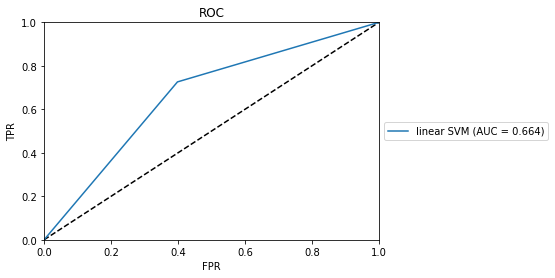


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               19414               12856
actual positive                 999                2649


In [48]:
get_results(val_y_arr, val_pred)